In [1]:
# Imports
import os
import json
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
import yaml


# For deep learning
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.ops import box_iou

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_recall_fscore_support
import numpy as np


# For augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Own package imports
os.chdir('/home/naro/projects/Rumex')

from src.augmentation import *
from src.dataset import *
from src.model_factory import *

from src.evaluate import *
from src.train import *
from src.inference import *
from utils.fiftyone_utils import *
from utils.data_inspection import *
from utils.viz_utils import *
from utils.data_utils import *
from utils.generic import *

VIZ = False

/home/naro/.conda/envs/rumex/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Verify all pathes for the dataset are working correctly

In [2]:
config_file = "/home/naro/projects/Rumex/config/configs.yaml"
config = read_yaml(config_file)

dataset_name = config['dataset']['dataset_name']
darwin_root = config['dataset']['darwin_root']
dataset_version = config['dataset']['dataset_version']
images_extension = config['dataset']['extension']


img_dir, annotations_dir, train_split_file, test_split_file, val_split_file = format_darwin_related_pathes(dataset_name, darwin_root, dataset_version)

# Initialize DataVerifier
data_verifier = DataVerifier(
    img_dir = img_dir,
    annotations_dir = annotations_dir,
    train_split_file = train_split_file,
    test_split_file = test_split_file,
    val_split_file = val_split_file,
    extension = images_extension
)

# Verify data
train_annotations, test_annotations, val_annotations = data_verifier.check_directory_contents()

# Initialize ImageProcessor
image_processor = ImagesClassesInspector(
    img_dir=img_dir,
    annotations_dir=annotations_dir
)

# Get image and annotation lists
train_images = data_verifier.get_image_files(train_annotations)
val_images = data_verifier.get_image_files(val_annotations)
test_images = data_verifier.get_image_files(test_annotations)

# Get image sizes
image_files = os.listdir(img_dir)
train_sizes = image_processor.get_image_sizes(image_files)

# Get classes
annotation_files = train_annotations + test_annotations + val_annotations
classes = image_processor.get_classes(annotation_files)
print("\nClasses in the dataset:")
print(classes)

class_map = {name: idx + 1 for idx, name in enumerate(classes)}
print("\nThe created class map:")
print(class_map)

# Get image size stats
min_size, max_size = image_processor.get_image_size_stats(image_files)
print(f"Smallest image size: {min_size}")
print(f"Largest image size: {max_size}")

w_min, h_min = min_size
print(f"Width of smallest image: {w_min}")
print(f"Height of smallest image: {h_min}")


Train: 2700, Test: 386, Val: 772
Checking directory contents...

First few images in image directory:
['DJI_20220901114709_0325_3_7.png', 'DJI_20220901115906_0600_8_5.png', 'DJI_20220901114344_0247_2_1.png', 'DJI_20220901114019_0169_5_3.png', 'DJI_20220901113935_0151_1_5.png']

First few annotations in annotation directory:
['DJI_20220901113924_0147_2_4.json', 'DJI_20220901114647_0315_3_6.json', 'DJI_20220901114011_0166_4_1.json', 'DJI_20220901114050_0181_6_7.json', 'DJI_20220901115158_0435_4_1.json']

First few lines in split files:
Train split:
['DJI_20220901114050_0181_3_2.json', 'DJI_20220901114249_0225_7_3.json', 'DJI_20220901114839_0359_3_0.json', 'DJI_20220901115357_0482_3_6.json', 'DJI_20220901114950_0386_2_1.json']

Test split:
['DJI_20220901115521_0514_3_5.json', 'DJI_20220901115042_0407_7_2.json', 'DJI_20220901115403_0484_3_3.json', 'DJI_20220901113319_0008_4_6.json', 'DJI_20220901113919_0145_5_5.json']

Val split:
['DJI_20220901113946_0155_2_1.json', 'DJI_20220901114205_020

# Configure the augmentations

In [3]:
# Initialize AugmentationConfig
augmentation_config = AugmentationConfig(height=h_min, width=w_min)

# Get transforms
train_transform = augmentation_config.get_train_transform()
valid_transform = augmentation_config.get_valid_transform()

# Print transform configurations
print("Training transforms:")
print(train_transform)
print("\nValidation transforms:")
print(valid_transform)


Training transforms:
ReplayCompose([
  HorizontalFlip(p=0.5),
  VerticalFlip(p=0.5),
  AtLeastOneBBoxRandomCrop(p=1.0, height=678, width=1024, erosion_factor=0.0),
  Rotate(p=0.5, limit=(-15.0, 15.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', crop_border=False, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0, 'min_visibility': 0.2, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True, 'clip': False, 'max_accept_ratio': None}, keypoint_params=None, additional_targets={}, is_check_shapes=True, save_key='replay')

Validation transforms:
Compose([
  Resize(p=1.0, height=678, width=1024, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixe

# Create Dataset Loaders

In [4]:

train_loader, val_loader, test_loader = create_data_loaders(
    img_dir=img_dir,
    annotation_dir=annotations_dir,
    train_images=train_images,
    train_annotations=train_annotations,
    val_images=val_images,
    val_annotations=val_annotations,
    test_images=test_images,
    test_annotations=test_annotations,
    train_transform=train_transform,
    valid_transform=valid_transform,
    class_map=class_map,
    batch_size=8, 
    num_workers=2
)

# Print the number of samples in each dataset
print(f"Number of samples in training dataset: {len(train_loader.dataset)}")
print(f"Number of samples in validation dataset: {len(val_loader.dataset)}")
print(f"Number of samples in test dataset: {len(test_loader.dataset)}")


Number of samples in training dataset: 2700
Number of samples in validation dataset: 386
Number of samples in test dataset: 772


# Visualize some samples

In [5]:
if VIZ:
    print("Visualizing samples:")
    for i in range(3):
        print(f"\nSample {i+1}:")
        visualize_sample(train_loader.dataset, class_map,idx=None, figsize=(5,5))

    
    # Visualize augmentations
    print("Visualizing original image with augmentations:")
    for i in range(5):
        visualize_augmentations(
            dataset_without_augmentation=RumexDataSet(
                img_dir=img_dir,
                annotation_dir=annotations_dir,
                images_list=train_images,
                annotations_list=train_annotations,
                transform=None,
                class_map=class_map
            ),
            dataset_with_augmentation=RumexDataSet(
                img_dir=img_dir,
                annotation_dir=annotations_dir,
                images_list=train_images,
                annotations_list=train_annotations,
                transform=train_transform,
                class_map=class_map
            ),
            classes=classes,
            num_augmented=5
        )


# Model Creation

In [6]:
config

{'dataset': {'dataset_name': 'haldennord09',
  'dataset_version': 'latest',
  'extension': 'png',
  'darwin_root': '/darwin/digital-production'},
 'dataloader': {'batch_size': 4, 'num_workers': 4},
 'model': {'model_name': 'fasterrcnn',
  'backbone': 'resnet50',
  'train_backbone': False,
  'weights': 'COCO_V1',
  'num_classes': 2,
  'optimizer': 'adam',
  'learning_rate': 0.0001,
  'epochs': 100,
  'models_dir': '/home/naro/projects/Rumex/artifacts/models'}}

In [7]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = init_model(model_name= config['model']['model_name'],
                   backbone_name=config['model']['backbone'],
                   num_classes=config['model']['num_classes'],
                   device=device,
                   weights=config['model']['weights'],
                   train_backbone=config['model']['train_backbone'])

# Print model summary
print("\nModel Overview:")
print(f"Model type: Faster R-CNN with ResNet50 backbone")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Using device: cuda

Model Overview:
Model type: Faster R-CNN with ResNet50 backbone
Number of parameters: 41299161
Number of trainable parameters: 14499865


# Experiment Setup

There are two way o run mlflow (or not) and work with it.

- Either I log everything to the generic server available. In this case, I have to:

1- start the server the terminal mlflow server --host 127.0.0.1 --port 5000

2- Set a tracking uri to the same port that was assigned to the server: mlflow.set_tracking_uri("http://localhost:5000")

- Or, I do not start any tracking server, in this case the experiments default to the folder location of the code from which the
code is executed.

1- Do not assign the port 5000 as a tracking uri.

2- mlflow ui --backend-store-uri /path/to/mlruns/

In [8]:
from torchinfo import summary
from datetime import datetime
import mlflow
from mlflow.models import infer_signature
 

# Before running the below code, one has to run the mlflow server so that
# it starts tracking the experiments: open a terminal

mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.set_tracking_uri("http://4.210.174.216:5000")



In [9]:
version =get_dataset_version_from_darwin(dataset_name, 'digital-production')
darwin_root = config['dataset']['darwin_root']
dataset_version = config['dataset']['dataset_version']
images_extension = config['dataset']['extension']

experiment_name = dataset_name + '_V' + version +  "_" + config['model']['model_name'] + "_" + config['model']['backbone'] + "_" + datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name

mlflow.set_experiment(experiment_name = experiment_name)

2025/05/14 15:20:48 INFO mlflow.tracking.fluent: Experiment with name 'haldennord09_V2_fasterrcnn_resnet50_20250514_152048' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/803526688886582779', creation_time=1747236048216, experiment_id='803526688886582779', last_update_time=1747236048216, lifecycle_stage='active', name='haldennord09_V2_fasterrcnn_resnet50_20250514_152048', tags={}>

# Model Training

In [10]:
params = config['model'] 
params

{'model_name': 'fasterrcnn',
 'backbone': 'resnet50',
 'train_backbone': False,
 'weights': 'COCO_V1',
 'num_classes': 2,
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'epochs': 100,
 'models_dir': '/home/naro/projects/Rumex/artifacts/models'}

In [11]:
TRAIN = True
if TRAIN:
    with mlflow.start_run():
        # Log training parameters.
        mlflow.log_params(params)

        # Log model summary.
        with open("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")

        train_model(model, train_loader, val_loader, config['model'] , device)


        # Save the trained model to MLflow.
        mlflow.pytorch.log_model(model, "model")

Training model...
Epoch: 0
Epoch: 0, Batch: 0, loss_classifier: 0.6020, loss_box_reg: 0.0152, loss_objectness: 0.3188, loss_rpn_box_reg: 0.0089, Total Loss: 0.9448
Epoch: 0, Batch: 50, loss_classifier: 0.1029, loss_box_reg: 0.0672, loss_objectness: 0.0747, loss_rpn_box_reg: 0.0097, Total Loss: 0.0040
Epoch: 0, Batch: 100, loss_classifier: 0.0954, loss_box_reg: 0.0771, loss_objectness: 0.0625, loss_rpn_box_reg: 0.0091, Total Loss: 0.0023
Epoch: 0, Batch: 150, loss_classifier: 0.0924, loss_box_reg: 0.0835, loss_objectness: 0.0525, loss_rpn_box_reg: 0.0080, Total Loss: 0.0023
Epoch: 0, Batch: 200, loss_classifier: 0.0923, loss_box_reg: 0.0863, loss_objectness: 0.0480, loss_rpn_box_reg: 0.0076, Total Loss: 0.0016
Epoch: 0, Batch: 250, loss_classifier: 0.0917, loss_box_reg: 0.0887, loss_objectness: 0.0459, loss_rpn_box_reg: 0.0074, Total Loss: 0.0008
Epoch: 0, Batch: 300, loss_classifier: 0.0907, loss_box_reg: 0.0902, loss_objectness: 0.0443, loss_rpn_box_reg: 0.0073, Total Loss: 0.0007
ten

2025/05/15 04:05:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzo44o599/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/05/15 04:05:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run clean-mule-84 at: http://localhost:5000/#/experiments/803526688886582779/runs/8cad6249ce3b448095d3d8e367f8a18b
🧪 View experiment at: http://localhost:5000/#/experiments/803526688886582779


# Inference on the test set

In [12]:
model = load_best_model(model = model,
                        best_model_path= "/home/naro/projects/Rumex/artifacts/models/best_model.pth")

Loaded model from epoch 87 with mAP@50: 0.4020


772


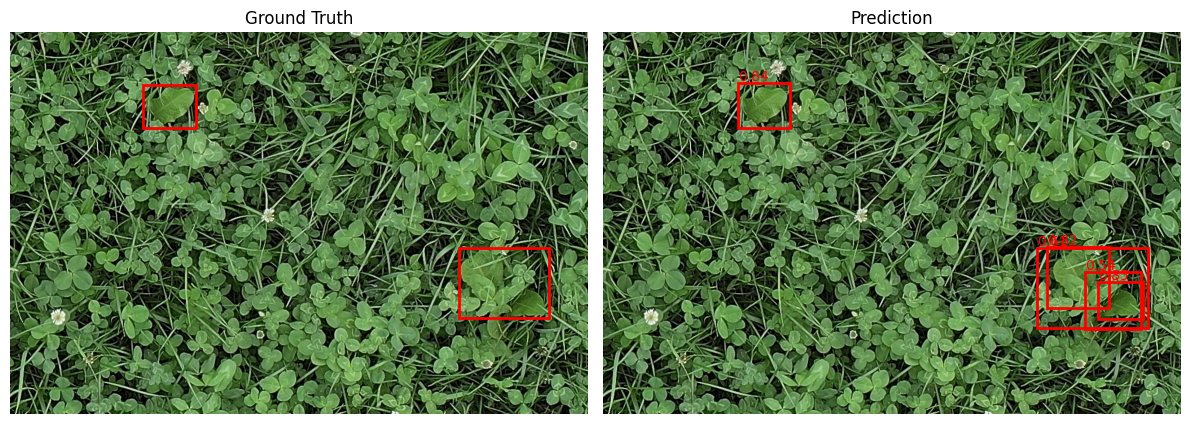


Ground Truth:
Number of objects: 2

Predictions (confidence > 0.5):
Number of detections: 5

Prediction scores: [0.84952885 0.8424435  0.8248189  0.6074904  0.5372215 ]


In [13]:
predict_and_visualize_image_from_dataloader(model, test_loader, idx=5, device = torch.device('cuda'), confidence_threshold=0.5, figsize=(12, 12))
